In [45]:
from plotnine import *
from scipy.spatial import distance
import pandas as pd
from dtw import *
import dtaidistance as dd
from tslearn import metrics
from dtaidistance import dtw_visualisation as dtwvis
import matplotlib.pyplot as plt

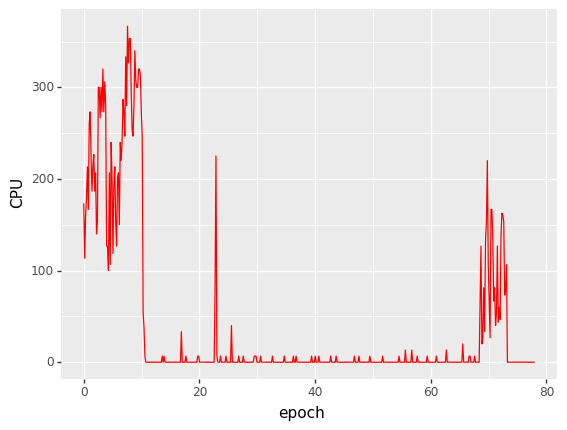

<ggplot: (85948169879)>

In [46]:
%matplotlib inline
joined_aggregation_all = pd.read_csv("Organised/aggregation/joined_aggregation.csv")
joined_aggregation = joined_aggregation_all[joined_aggregation_all["snapshot"] == 1]

(ggplot(joined_aggregation)         # defining what data to use
  + aes(x='epoch', y = "CPU")    # defining what variable to use
  + geom_line(size=0.5, color = "red") # defining the type of plot to use
 )

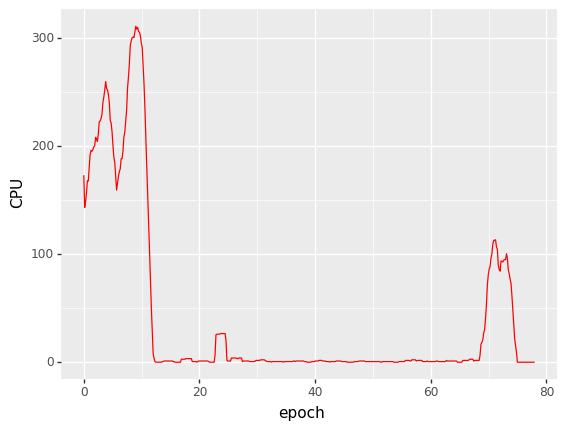

<ggplot: (85946647715)>

In [47]:
joined_aggregation_smooth_all = pd.read_csv("Organised/aggregation/12_joined_smooth_aggregation.csv")
joined_aggregation_smooth = joined_aggregation_smooth_all[joined_aggregation_smooth_all["snapshot"] == 1]

(ggplot(joined_aggregation_smooth)         # defining what data to use
 + aes(x='epoch', y = "CPU")    # defining what variable to use
 + geom_line(size=0.5, color = "red") # defining the type of plot to use
)

In [48]:
normalized_joined_aggregation_smooth_all = pd.read_csv("Organised/aggregation/6_normalized_smooth_aggregation.csv")
normalized_aggregation = pd.read_csv("Organised/aggregation/normalized_aggregation.csv")

joined_filtration_smooth_all = pd.read_csv("Organised/filtration/6_joined_smooth_filtration.csv")
joined_filtration_all = pd.read_csv("Organised/filtration/joined_filtration.csv")
normalized_joined_filtration_smooth_all = pd.read_csv("Organised/filtration/6_normalized_smooth_filtration.csv")
normalized_joined_filtration = pd.read_csv("Organised/filtration/normalized_filtration.csv")

joined_aggregation_filtration_smooth_all = pd.read_csv("Organised/filtration-aggregation/6_joined_smooth_filtration-aggregation.csv")
joined_aggregation_filtration_all = pd.read_csv("Organised/filtration-aggregation/joined_filtration-aggregation.csv")
normalized_joined_aggregation_filtration_smooth_all = pd.read_csv("Organised/filtration-aggregation/6_normalized_smooth_filtration-aggregation.csv")
normalized_joined_aggregation_filtration = pd.read_csv("Organised/filtration-aggregation/normalized_filtration-aggregation.csv")

In [66]:
def calculate_euclidean_distance(data, snapshot1, snapshot2, max_length):
    a = data[data["snapshot"] == snapshot1].head(max_length)
    b = data[data["snapshot"] == snapshot2].head(max_length)
    cpu_dst = distance.euclidean(a['CPU'], b['CPU'])
    ram_dst = distance.euclidean(a['RAM'], b['RAM'])
    return cpu_dst, ram_dst

def calculate_dtw_dtw_library(data, snapshot1, snapshot2, data2=pd.DataFrame()):
    if data2.empty:
        data2 = data
    a = data[data["snapshot"] == snapshot1]
    b = data2[data2["snapshot"] == snapshot2]
    step_pattern = symmetric2
    alignment_cpu = dtw(a['CPU'], b['CPU'], step_pattern=step_pattern, keep_internals=True)
    alignment_ram = dtw(a['RAM'], b['RAM'], step_pattern=step_pattern, keep_internals=True)
    #alignment_cpu.plot(type="twoway", offset=80)
    #plt.show()
    return alignment_cpu.normalizedDistance, alignment_cpu.distance, alignment_ram.normalizedDistance, alignment_ram.distance

def calculate_dtw_dtaidistance_library(data, snapshot1, snapshot2, data2=pd.DataFrame()):
    if data2.empty:
        data2 = data
    a = data[data["snapshot"] == snapshot1]
    b = data2[data2["snapshot"] == snapshot2]
    d_cpu = dd.dtw.distance(a['CPU'].to_numpy(), b['CPU'].to_numpy(), None, None, None, None, None, None, None, True)
    #path = dd.dtw.warping_path(a['CPU'].to_numpy(), b['CPU'].to_numpy())
    #dtwvis.plot_warping(a['CPU'].to_numpy(), b['CPU'].to_numpy(), path)

    d_ram = dd.dtw.distance(a['RAM'].to_numpy(), b['RAM'].to_numpy())
    return d_cpu, d_ram

def calculate_lcss(data, snapshot1, snapshot2, data2=pd.DataFrame()):
    if data2.empty:
        data2 = data
    a = data[data["snapshot"] == snapshot1]
    b = data2[data2["snapshot"] == snapshot2]
    lcss_path_cpu, sim_lcss_cpu = metrics.lcss_path(a['CPU'], b['CPU'], eps=1.0)
    lcss_path_ram, sim_lcss_ram = metrics.lcss_path(a['RAM'], b['RAM'], eps=1.0)
    return sim_lcss_cpu, sim_lcss_ram

In [35]:
def draw_comparison_diagram(data, snapshot1, snapshot2, title="Title", y_data = "CPU", data2=pd.DataFrame(), max_length=496):
    if data2.empty:
        data2 = data
    a = data[data["snapshot"] == snapshot1]
    b = data2[data2["snapshot"] == snapshot2]
    comparison_data = pd.concat([a, b])
    euc_cpu_dist, euc_ram_dist = calculate_euclidean_distance(comparison_data, snapshot1, snapshot2, max_length)
    dtw_cpu_dist_normalized, dtw_cpu_dist, dtw_ram_dist_normalized, dtw_ram_dist = \
        calculate_dtw_dtw_library(a, snapshot1, snapshot2, b)
    dtaidistance_cpu, dtaidistance_ram = calculate_dtw_dtaidistance_library(a, snapshot1, snapshot2, b)
    if y_data == "CPU":
        euc_dist = euc_cpu_dist
        dtw_dist_normalized = dtw_cpu_dist_normalized
        dtw_dist = dtw_cpu_dist
        dtaidistance = dtaidistance_cpu
    else:
        euc_dist = euc_ram_dist
        dtw_dist_normalized = dtw_ram_dist_normalized
        dtw_dist = dtw_ram_dist
        dtaidistance = dtaidistance_ram
    return qplot(data=comparison_data, x="epoch", y=y_data,
          facets="snapshot",
          color = "factor(snapshot)",
          geom="line",
          xlab="Epoch", ylab=y_data,
          main=title
               + "\nEuclidan distance:"+ str(round(euc_dist, 2))
               + "\nDTW normalized distance - dtw library:"+ str(round(dtw_dist_normalized, 2))
               + "\nDTW distance - dtw library:"+ str(round(dtw_dist, 2))
               + "\nDTW distance - dtaidistance library:"+ str(round(dtaidistance, 2))) \
    + \
    theme(figure_size=(11,6))

## Distance - identical data

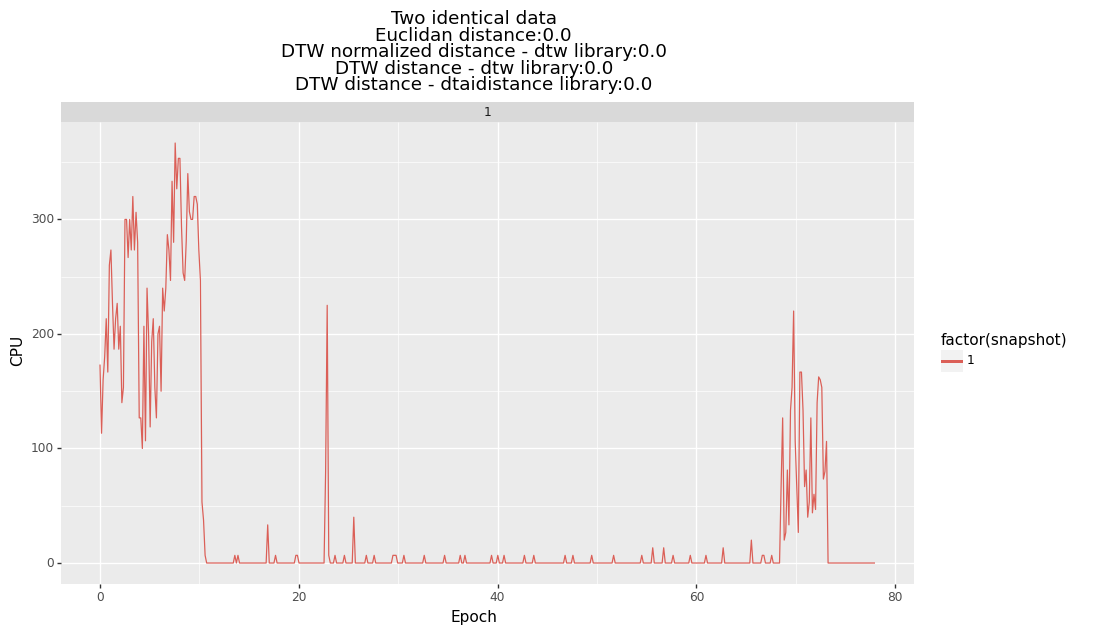

In [8]:
print(draw_comparison_diagram(joined_aggregation_all, 1, 1, "Two identical data"))

## Distance - joined aggregation

In [ ]:
## CPU
print(draw_comparison_diagram(joined_aggregation_all, 0, 1, "Aggregation 0 1"))
print(draw_comparison_diagram(joined_aggregation_all, 0, 2, "Aggregation 0 2"))
print(draw_comparison_diagram(joined_aggregation_all, 1, 2, "Aggregation 1 2"))
## RAM
print(draw_comparison_diagram(joined_aggregation_all, 0, 1, "Aggregation 0 1", "RAM"))
print(draw_comparison_diagram(joined_aggregation_all, 0, 2, "Aggregation 0 2", "RAM"))
print(draw_comparison_diagram(joined_aggregation_all, 1, 2, "Aggregation 1 2", "RAM"))

## Distance - normalized aggregation

In [ ]:
## CPU
print(draw_comparison_diagram(normalized_aggregation, 0, 1, "Aggregation 0 1"))
print(draw_comparison_diagram(normalized_aggregation, 0, 2, "Aggregation 0 2"))
print(draw_comparison_diagram(normalized_aggregation, 1, 2, "Aggregation 1 2"))
## RAM
print(draw_comparison_diagram(normalized_aggregation, 0, 1, "Aggregation 0 1", "RAM"))
print(draw_comparison_diagram(normalized_aggregation, 0, 2, "Aggregation 0 2", "RAM"))
print(draw_comparison_diagram(normalized_aggregation, 1, 2, "Aggregation 1 2", "RAM"))

## Distance - smooth aggregation

In [ ]:
## CPU
print(draw_comparison_diagram(joined_aggregation_smooth_all, 0, 1, "Smooth aggregation 0 1"))
print(draw_comparison_diagram(joined_aggregation_smooth_all, 0, 2, "Smooth aggregation 0 2"))
print(draw_comparison_diagram(joined_aggregation_smooth_all, 1, 2, "Smooth aggregation 1 2"))
## RAM
print(draw_comparison_diagram(joined_aggregation_smooth_all, 0, 1, "Smooth aggregation 0 1", "RAM"))
print(draw_comparison_diagram(joined_aggregation_smooth_all, 0, 2, "Smooth aggregation 0 2", "RAM"))
print(draw_comparison_diagram(joined_aggregation_smooth_all, 1, 2, "Smooth aggregation 1 2", "RAM"))

## Distance - normalized smooth aggregation

In [ ]:
## CPU
print(draw_comparison_diagram(normalized_joined_aggregation_smooth_all, 0, 1, "Smooth aggregation 0 1"))
print(draw_comparison_diagram(normalized_joined_aggregation_smooth_all, 0, 2, "Smooth aggregation 0 2"))
print(draw_comparison_diagram(normalized_joined_aggregation_smooth_all, 1, 2, "Smooth aggregation 1 2"))
## RAM
print(draw_comparison_diagram(normalized_joined_aggregation_smooth_all, 0, 1, "Smooth aggregation 0 1", "RAM"))
print(draw_comparison_diagram(normalized_joined_aggregation_smooth_all, 0, 2, "Smooth aggregation 0 2", "RAM"))
print(draw_comparison_diagram(normalized_joined_aggregation_smooth_all, 1, 2, "Smooth aggregation 1 2", "RAM"))

## Distance - filtration vs aggregation

In [ ]:
# Compare two different functions
## CPU
print(draw_comparison_diagram(joined_aggregation_all, 0, 1,  "Aggregation vs Filtration 0 1", "CPU", joined_filtration_all, 151))
print(draw_comparison_diagram(joined_aggregation_all, 0, 2,  "Aggregation vs Filtration 0 2", "CPU", joined_filtration_all, 139))
print(draw_comparison_diagram(joined_aggregation_all, 1, 2,  "Aggregation vs Filtration 1 2", "CPU", joined_filtration_all, 139))

## RAM
print(draw_comparison_diagram(joined_aggregation_all, 0, 1,  "Aggregation vs Filtration 0 1", "RAM", joined_filtration_all, 151))
print(draw_comparison_diagram(joined_aggregation_all, 0, 2,  "Aggregation vs Filtration 0 2", "RAM", joined_filtration_all, 139))
print(draw_comparison_diagram(joined_aggregation_all, 1, 2,  "Aggregation vs Filtration 1 2", "RAM", joined_filtration_all, 139))

## Distance - normalized filtration vs aggregation

In [ ]:
# Compare two different functions
## CPU
print(draw_comparison_diagram(normalized_aggregation, 0, 1,  "Aggregation vs Filtration 0 1", "CPU", normalized_joined_filtration, 151))
print(draw_comparison_diagram(normalized_aggregation, 0, 2,  "Aggregation vs Filtration 0 2", "CPU", normalized_joined_filtration, 139))
print(draw_comparison_diagram(normalized_aggregation, 1, 2,  "Aggregation vs Filtration 1 2", "CPU", normalized_joined_filtration, 139))

## RAM
print(draw_comparison_diagram(normalized_aggregation, 0, 1,  "Aggregation vs Filtration 0 1", "RAM", normalized_joined_filtration, 151))
print(draw_comparison_diagram(normalized_aggregation, 0, 2,  "Aggregation vs Filtration 0 2", "RAM", normalized_joined_filtration, 139))
print(draw_comparison_diagram(normalized_aggregation, 1, 2,  "Aggregation vs Filtration 1 2", "RAM", normalized_joined_filtration, 139))

## Distance - smooth filtration vs aggregation

In [ ]:
# Compare two different functions
## CPU
print(draw_comparison_diagram(joined_aggregation_smooth_all, 0, 1,  "Aggregation vs Filtration 0 1", "CPU", joined_filtration_smooth_all, 151))
print(draw_comparison_diagram(joined_aggregation_smooth_all, 0, 2,  "Aggregation vs Filtration 0 2", "CPU", joined_filtration_smooth_all, 139))
print(draw_comparison_diagram(joined_aggregation_smooth_all, 1, 2,  "Aggregation vs Filtration 1 2", "CPU", joined_filtration_smooth_all, 139))

## RAM
print(draw_comparison_diagram(joined_aggregation_smooth_all, 0, 1,  "Aggregation vs Filtration 0 1", "RAM", joined_filtration_smooth_all, 151))
print(draw_comparison_diagram(joined_aggregation_smooth_all, 0, 2,  "Aggregation vs Filtration 0 2", "RAM", joined_filtration_smooth_all, 139))
print(draw_comparison_diagram(joined_aggregation_smooth_all, 1, 2,  "Aggregation vs Filtration 1 2", "RAM", joined_filtration_smooth_all, 139))

## Distance - normalized smooth filtration vs aggregation

In [ ]:
# Compare two different functions
## CPU
print(draw_comparison_diagram(normalized_joined_aggregation_smooth_all, 0, 1,  "Aggregation vs Filtration 0 1", "CPU", normalized_joined_filtration_smooth_all, 151))
print(draw_comparison_diagram(normalized_joined_aggregation_smooth_all, 0, 2,  "Aggregation vs Filtration 0 2", "CPU", normalized_joined_filtration_smooth_all, 139))
print(draw_comparison_diagram(normalized_joined_aggregation_smooth_all, 1, 2,  "Aggregation vs Filtration 1 2", "CPU", normalized_joined_filtration_smooth_all, 139))

## RAM
print(draw_comparison_diagram(normalized_joined_aggregation_smooth_all, 0, 1,  "Aggregation vs Filtration 0 1", "RAM", normalized_joined_filtration_smooth_all, 151))
print(draw_comparison_diagram(normalized_joined_aggregation_smooth_all, 0, 2,  "Aggregation vs Filtration 0 2", "RAM", normalized_joined_filtration_smooth_all, 139))
print(draw_comparison_diagram(normalized_joined_aggregation_smooth_all, 1, 2,  "Aggregation vs Filtration 1 2", "RAM", normalized_joined_filtration_smooth_all, 139))

## Creating comparison dataFrame

In [50]:
def calculate_distance_and_save_as_df(df, data, snapshot1, snapshot2, function1, function2, normalized=0, smoothed=0, data2=pd.DataFrame(), max_length=496):
    if data2.empty:
        data2 = data
    a = data[data["snapshot"] == snapshot1]
    b = data2[data2["snapshot"] == snapshot2]
    max_length = min(len(a.index), len(b.index))
    comparison_data = pd.concat([a, b])
    euc_cpu_dist, euc_ram_dist = calculate_euclidean_distance(comparison_data, snapshot1, snapshot2, max_length)
    dtw_cpu_dist_normalized, dtw_cpu_dist, dtw_ram_dist_normalized, dtw_ram_dist = \
        calculate_dtw_dtw_library(a, snapshot1, snapshot2, b)
    dtaidistance_cpu, dtaidistance_ram = calculate_dtw_dtaidistance_library(a, snapshot1, snapshot2, b)
    lcss_distance_cpu, lcss_distance_ram = calculate_lcss(a, snapshot1, snapshot2, b)
    new_cpu_row = {
        'dataType' : 'CPU',
        'function1' : function1,
        'snapshot1' : snapshot1,
        'udf1' : a['udf'].max(),
        'function2' : function2,
        'snapshot2': snapshot2,
        'udf2' : b['udf'].max(),
        'euclidean': euc_cpu_dist,
        'dtw-python-distance': dtw_cpu_dist,
        'dtw-python-normalizedDistance': dtw_cpu_dist_normalized,
        'dtaidistance': dtaidistance_cpu,
        'lcss_similarity': lcss_distance_cpu,
        'is_normalized': normalized,
        'is_smoothed': smoothed
    }
    new_ram_row = {
        'dataType' : 'RAM',
        'function1' : function1,
        'snapshot1' : snapshot1,
        'udf1' : a['udf'].max(),
        'function2' : function2,
        'snapshot2': snapshot2,
        'udf2' : b['udf'].max(),
        'euclidean': euc_ram_dist,
        'dtw-python-distance': dtw_ram_dist,
        'dtw-python-normalizedDistance': dtw_ram_dist_normalized,
        'dtaidistance': dtaidistance_ram,
        'lcss_similarity': lcss_distance_ram,
        'is_normalized': normalized,
        'is_smoothed': smoothed
    }
    df = df.append(new_cpu_row, ignore_index = True)
    df = df.append(new_ram_row, ignore_index = True)
    return df

In [67]:
columns = ['dataType', 'function1', 'snapshot1','function2', 'snapshot2', 'euclidean', 'dtw-python-distance', 'dtw-python-normalizedDistance',
           'dtaidistance', 'lcss_similarity', 'is_normalized', 'is_smoothed']
dataFrame = pd.DataFrame([], columns = columns)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_all, 1, 1, "aggregation", "aggregation")
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_all, 0, 1, "aggregation", "aggregation")
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_all, 0, 2, "aggregation", "aggregation")
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_all, 1, 150, "aggregation", "aggregation")
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_aggregation, 0, 1, "aggregation", "aggregation", 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_aggregation, 0, 2, "aggregation", "aggregation", 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_aggregation, 1, 150, "aggregation", "aggregation", 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_smooth_all, 0, 1, "aggregation", "aggregation", 0, 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_smooth_all, 0, 2, "aggregation", "aggregation", 0, 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_smooth_all, 1, 150, "aggregation", "aggregation", 0, 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_aggregation_smooth_all, 0, 1, "aggregation", "aggregation", 1, 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_aggregation_smooth_all, 0, 2, "aggregation", "aggregation", 1, 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_aggregation_smooth_all, 1, 150, "aggregation", "aggregation", 1, 1)

In [68]:
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_filtration_all, 1, 1, "filtration", "filtration")
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_filtration_all, 0, 1, "filtration", "filtration")
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_filtration_all, 0, 2, "filtration", "filtration")
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_filtration_all, 1, 150, "filtration", "filtration")
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_filtration, 0, 1, "filtration", "filtration", 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_filtration, 0, 2, "filtration", "filtration", 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_filtration, 1, 150, "filtration", "filtration", 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_filtration_smooth_all, 0, 1, "filtration", "filtration", 0, 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_filtration_smooth_all, 0, 2, "filtration", "filtration", 0, 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_filtration_smooth_all, 1, 150, "filtration", "filtration", 0, 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_filtration_smooth_all, 0, 1, "filtration", "filtration", 1, 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_filtration_smooth_all, 0, 2, "filtration", "filtration", 1, 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_filtration_smooth_all, 1, 150, "filtration", "filtration", 1, 1)

In [69]:
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_filtration_all, 1, 1, "filtration-aggregation", "filtration-aggregation")
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_filtration_all, 0, 1, "filtration-aggregation", "filtration-aggregation")
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_filtration_all, 0, 2, "filtration-aggregation", "filtration-aggregation")
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_filtration_all, 1, 2, "filtration-aggregation", "filtration-aggregation")
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_aggregation_filtration, 0, 1, "filtration-aggregation", "filtration-aggregation", 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_aggregation_filtration, 0, 2, "filtration-aggregation", "filtration-aggregation", 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_aggregation_filtration, 1, 2, "filtration-aggregation", "filtration-aggregation", 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_filtration_smooth_all, 0, 1, "filtration-aggregation", "filtration-aggregation", 0, 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_filtration_smooth_all, 0, 2, "filtration-aggregation", "filtration-aggregation", 0, 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_filtration_smooth_all, 1, 2, "filtration-aggregation", "filtration-aggregation", 0, 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_aggregation_filtration_smooth_all, 0, 1, "filtration-aggregation", "filtration-aggregation", 1, 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_aggregation_filtration_smooth_all, 0, 2, "filtration-aggregation", "filtration-aggregation", 1, 1)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_aggregation_filtration_smooth_all, 1, 2, "filtration-aggregation", "filtration-aggregation", 1, 1)

In [70]:
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_all, 0, 1, "aggregation", "filtration", 0, 0, joined_filtration_all, 151)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_all, 0, 2, "aggregation", "filtration", 0, 0, joined_filtration_all, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_all, 1, 2, "aggregation", "filtration", 0, 0, joined_filtration_all, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_filtration_all, 1, 0, "filtration", "aggregation", 0, 0, joined_aggregation_all, 151)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_filtration_all, 2, 0, "filtration", "aggregation", 0, 0, joined_aggregation_all, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_filtration_all, 2, 1, "filtration", "aggregation", 0, 0, joined_aggregation_all, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_aggregation, 0, 1, "aggregation", "filtration", 1, 0, normalized_joined_filtration, 151)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_aggregation, 0, 2, "aggregation", "filtration", 1, 0, normalized_joined_filtration, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_aggregation, 1, 2, "aggregation", "filtration", 1, 0, normalized_joined_filtration, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_smooth_all, 0, 1, "aggregation", "filtration", 0, 1, joined_filtration_smooth_all, 151)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_smooth_all, 0, 2, "aggregation", "filtration", 0, 1, joined_filtration_smooth_all, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_smooth_all, 1, 2, "aggregation", "filtration", 0, 1, joined_filtration_smooth_all, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_aggregation_smooth_all, 0, 1, "aggregation", "filtration", 1, 1, normalized_joined_filtration_smooth_all, 151)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_aggregation_smooth_all, 0, 2, "aggregation", "filtration", 1, 1, normalized_joined_filtration_smooth_all, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_aggregation_smooth_all, 1, 2, "aggregation", "filtration", 1, 1, normalized_joined_filtration_smooth_all, 139)

In [71]:
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_all, 0, 1, "aggregation", "filtration-aggregation", 0, 0, joined_aggregation_filtration_all, 151)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_all, 0, 2, "aggregation", "filtration-aggregation", 0, 0, joined_aggregation_filtration_all, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_all, 1, 2, "aggregation", "filtration-aggregation", 0, 0, joined_aggregation_filtration_all, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_aggregation, 0, 1, "aggregation", "filtration-aggregation", 1, 0, normalized_joined_aggregation_filtration, 151)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_aggregation, 0, 2, "aggregation", "filtration-aggregation", 1, 0, normalized_joined_aggregation_filtration, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_aggregation, 1, 2, "aggregation", "filtration-aggregation", 1, 0, normalized_joined_aggregation_filtration, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_smooth_all, 0, 1, "aggregation", "filtration-aggregation", 0, 1, joined_aggregation_filtration_smooth_all, 151)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_smooth_all, 0, 2, "aggregation", "filtration-aggregation", 0, 1, joined_aggregation_filtration_smooth_all, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_aggregation_smooth_all, 1, 2, "aggregation", "filtration-aggregation", 0, 1, joined_aggregation_filtration_smooth_all, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_aggregation_smooth_all, 0, 1, "aggregation", "filtration-aggregation", 1, 1, normalized_joined_aggregation_filtration_smooth_all, 151)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_aggregation_smooth_all, 0, 2, "aggregation", "filtration-aggregation", 1, 1, normalized_joined_aggregation_filtration_smooth_all, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_aggregation_smooth_all, 1, 2, "aggregation", "filtration-aggregation", 1, 1, normalized_joined_aggregation_filtration_smooth_all, 139)


In [72]:
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_filtration_all, 0, 1, "filtration", "filtration-aggregation", 0, 0, joined_aggregation_filtration_all, 151)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_filtration_all, 0, 2, "filtration", "filtration-aggregation", 0, 0, joined_aggregation_filtration_all, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_filtration_all, 1, 2, "filtration", "filtration-aggregation", 0, 0, joined_aggregation_filtration_all, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_filtration, 0, 1, "filtration", "filtration-aggregation", 1, 0, normalized_joined_aggregation_filtration, 151)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_filtration, 0, 2, "filtration", "filtration-aggregation", 1, 0, normalized_joined_aggregation_filtration, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_filtration, 1, 2, "filtration", "filtration-aggregation", 1, 0, normalized_joined_aggregation_filtration, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_filtration_smooth_all, 0, 1, "filtration", "filtration-aggregation", 0, 1, joined_aggregation_filtration_smooth_all, 151)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_filtration_smooth_all, 0, 2, "filtration", "filtration-aggregation", 0, 1, joined_aggregation_filtration_smooth_all, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, joined_filtration_smooth_all, 1, 2, "filtration", "filtration-aggregation", 0, 1, joined_aggregation_filtration_smooth_all, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_filtration_smooth_all, 0, 1, "filtration", "filtration-aggregation", 1, 1, normalized_joined_aggregation_filtration_smooth_all, 151)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_filtration_smooth_all, 0, 2, "filtration", "filtration-aggregation", 1, 1, normalized_joined_aggregation_filtration_smooth_all, 139)
dataFrame = calculate_distance_and_save_as_df(dataFrame, normalized_joined_filtration_smooth_all, 1, 2, "filtration", "filtration-aggregation", 1, 1, normalized_joined_aggregation_filtration_smooth_all, 139)

In [73]:
dataFrame.to_csv("comparison_distance.csv", index=False)
dataFrame


,dataType,function1,snapshot1,function2,snapshot2,euclidean,dtw-python-distance,dtw-python-normalizedDistance,dtaidistance,lcss_similarity,is_normalized,is_smoothed,udf1,udf2
0,CPU,aggregation,1,aggregation,1,0.000000,0.00,0.000000,0.000000,1.000000,0,0,avgNetProfitGroupedBySoldDate,avgNetProfitGroupedBySoldDate
1,RAM,aggregation,1,aggregation,1,0.000000,0.00,0.000000,0.000000,1.000000,0,0,avgNetProfitGroupedBySoldDate,avgNetProfitGroupedBySoldDate
2,CPU,aggregation,0,aggregation,1,982.234453,3901.60,3.684230,313.896432,0.814516,0,0,avgNetProfitGroupedBySoldDate,avgNetProfitGroupedBySoldDate
3,RAM,aggregation,0,aggregation,1,34.884524,38.90,0.036733,2.009975,0.991935,0,0,avgNetProfitGroupedBySoldDate,avgNetProfitGroupedBySoldDate
4,CPU,aggregation,0,aggregation,2,745.357927,3646.50,3.255804,282.452669,0.813285,0,0,avgNetProfitGroupedBySoldDate,avgNetProfitGroupedBySoldDate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,RAM,filtration,0,filtration-aggregation,1,2.913280,16.37,0.023622,0.694406,1.000000,1,1,filterCatalogSalesWhereProfitNegative,avgNetProfitGroupedBySoldDateWhereProfitNegative
152,CPU,filtration,0,filtration-aggregation,2,1.727628,9.64,0.014156,1.368137,1.000000,1,1,filterCatalogSalesWhereProfitNegative,avgNetProfitGroupedBySoldDateWhereProfitNegative
153,RAM,filtration,0,filtration-aggregation,2,3.671703,63.86,0.093774,2.927815,1.000000,1,1,filterCatalogSalesWhereProfitNegative,avgNetProfitGroupedBySoldDateWhereProfitNegative
154,CPU,filtration,1,filtration-aggregation,2,1.926837,8.52,0.012529,1.254552,1.000000,1,1,filterCatalogSalesWhereProfitNegative,avgNetProfitGroupedBySoldDateWhereProfitNegative
